In [ ]:
# importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re     # importing regular expression

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

!pip install umap-learn
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

# ***Loading Data***

In [ ]:
# download dataset
!wget https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/CompanyX_clustering.csv

--2024-08-26 17:50:14--  https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/scaler_clustering.csv
Resolving d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)... 13.224.9.103, 13.224.9.129, 13.224.9.24, ...
Connecting to d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)|13.224.9.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24735965 (24M) [text/plain]
Saving to: ‘scaler_clustering.csv.6’

scaler_clustering.c 100%[===================>]  23.59M  --.-KB/s    in 0.1s    

2024-08-26 17:50:14 (160 MB/s) - ‘scaler_clustering.csv.6’ saved [24735965/24735965]



In [ ]:
# loading data in a dataframe
df = pd.read_csv('scaler_clustering.csv')
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


# ***1. Problem Statement and Exploratory Data Analysis (Non Graphical)***

**Problem Statement:**:
As a data scientist with the analytics vertical of CompanyX, perform Learners and Company Profiling to group learners with similar characteristics to customize their learning experience, ensuring a more personalized
and impactful learning experience.

1. Perform learners profiling by clustering the learners based on similar characteristics like current job profile, companies, experience, etc. which will help in understanding their diverse background, tailor content
recommendations, customize their learning experience and provide specialized mentorship.

2. Perform company profiling by clustering learners based on professional background and preferences will help in uncovering patterns to identify the best approach to improvise their learning experience based on their background.


<br>


**1. Define Problem Statement and perform Exploratory Data Analysis (10 points)**

- Definition of problem (as per given problem statement with additional views)
- Observations on shape of data, data types of all the attributes, conversion of categorical attributes to 'category' (If required), missing value detection, statistical summary.
- Univariate Analysis (distribution plots of all the continuous variable(s) barplots/countplots of all the categorical variables)
- Bivariate Analysis (Relationships between important variables)
- Illustrate the insights based on EDA
>* Comments on range of attributes, outliers of various attributes
>* Comments on the distribution of the variables and relationship between them
>* Comments for each univariate and bivariate plots


**2. Data Pre-processing: (30 Points)**
- Mean/ KNN Imputation
- Regex for cleaning company names
- Standardization & Encoding

In [ ]:
# Creating a function to inspect various aspects of the raw data

from tabulate import tabulate

def data_inspection(df):
  '''
  Description: This function returns basic details about the dataset to perform data inspection:
               1) Rows and columns of the DataFrame
               2) General information about the DataFrame
               3) Number of NULL or missing values in the DataFrame in each column.
  '''
  print("(Rows,Columns) of DataFrame: ",df.shape)  # shape of the data
  print("********************************************************************************")
  print("General Information: \n",tabulate(df.info()))   # general info about the data
  print("********************************************************************************")
  print("# null values in Features: \n\n",df.isnull().sum())     # Number of null values on each column of the data
  print("********************************************************************************")

In [ ]:
# Function to identify unique value and counts for discrete or categorical data and min max value for continous numerical data

def unique_data(df):
    '''
    Description: unique_data(df) prints unique values and counts present in columns.
                 Features are divided into:
                 Discrete features - Numerical features with less than 10 unique values
                 Continuous features - Numerical features with more than 10 unique values
                 Categorical features - With data type as object

    Input:       The DataFrame for which unique values are required to be printed

    Output:      - Prints value_counts() for Discrete Numerical and Categorcial Features and Min, Max values for Continuous Numerical Features
                 - Returns the list of categorical_features, discrete_features, continuous_features in that order
    '''
    discrete_features = []
    continuous_features = []
    categorical_features = []

    # Iterate through each column in the DataFrame
    for feature in df.columns:
      if df[feature].dtype == object:
        categorical_features.append(feature)
      elif df[feature].nunique() <= 10:
        discrete_features.append(feature)
      else:
        continuous_features.append(feature)

    # Unique values for Discrete Numerical features
    for ft in discrete_features:
      print("Unique values for ", df[ft].value_counts())            # Print the unique values and their counts
      print("********************************************************")  # Print a separator

    # Unique values for Continuous Numerical features
    for ft in continuous_features:
      print(f" (Min,Max) for {ft}: {df[ft].min(), df[ft].max()}")           # Print the unique values and their counts
      print("********************************************************")     # Print a separator

    # Unique values for Categorical non Numerical features
    for ft in categorical_features:
      print("Unique values for ", df[ft].value_counts())            # Print the unique values and their counts
      print("********************************************************")  # Print a separator

    return categorical_features, discrete_features, continuous_features

In [ ]:
# Summary of details about the data
data_inspection(df)

(Rows,Columns) of DataFrame:  (205843, 7)
********************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB
General Information: 
 
********************************************************************************
# null values in Features: 

 Unnamed: 0              0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_pos

In [ ]:
# statistical summary of numerical data
df.describe()

,Unnamed: 0,orgyear,ctc,ctc_updated_year
count,205843.000000,205757.000000,2.058430e+05,205843.000000
mean,103273.941786,2014.882750,2.271685e+06,2019.628231
std,59741.306484,63.571115,1.180091e+07,1.325104
min,0.000000,0.000000,2.000000e+00,2015.000000
25%,51518.500000,2013.000000,5.300000e+05,2019.000000
50%,103151.000000,2016.000000,9.500000e+05,2020.000000
75%,154992.500000,2018.000000,1.700000e+06,2021.000000
max,206922.000000,20165.000000,1.000150e+09,2021.000000


In [ ]:
# statistical summary of catgorical data
df.describe(include = object)

,company_hash,email_hash,job_position
count,205799,205843,153279
unique,37299,153443,1016
top,nvnv wgzohrnvzwj otqcxwto,bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...,Backend Engineer
freq,8337,10,43554


In [ ]:
# identify unique values in the dataset
unique_data(df)

Unique values for  ctc_updated_year
2019.0    68688
2021.0    64976
2020.0    49444
2017.0     7561
2018.0     6746
2016.0     5501
2015.0     2927
Name: count, dtype: int64
********************************************************
 (Min,Max) for Unnamed: 0: (0, 206922)
********************************************************
 (Min,Max) for orgyear: (0.0, 20165.0)
********************************************************
 (Min,Max) for ctc: (2, 1000150000)
********************************************************
Unique values for  company_hash
nvnv wgzohrnvzwj otqcxwto         8337
xzegojo                           5381
vbvkgz                            3481
zgn vuurxwvmrt vwwghzn            3411
wgszxkvzn                         3240
                                  ... 
onvqmhwpo                            1
bvsxw ogenfvqt uqxcvnt rxbxnta       1
agsbv ojontbo                        1
vnnhzt xzegwgb                       1
bvptbjnqxu td vbvkgz                 1
Name: count, Length: 37

(['company_hash', 'email_hash', 'job_position'],
 ['ctc_updated_year'],
 ['Unnamed: 0', 'orgyear', 'ctc'])

In [ ]:
# list of unique org year
orgyear = pd.DataFrame(df['orgyear'].value_counts().reset_index())
orgyear.columns = ['orgyear','count']
orgyear[orgyear['count'] < 22].nunique()

,0
orgyear,41
count,11


In [ ]:
# number of unique job positions
df['job_position'].nunique(), df['company_hash'].nunique(), df['email_hash'].nunique()

(1016, 37299, 153443)

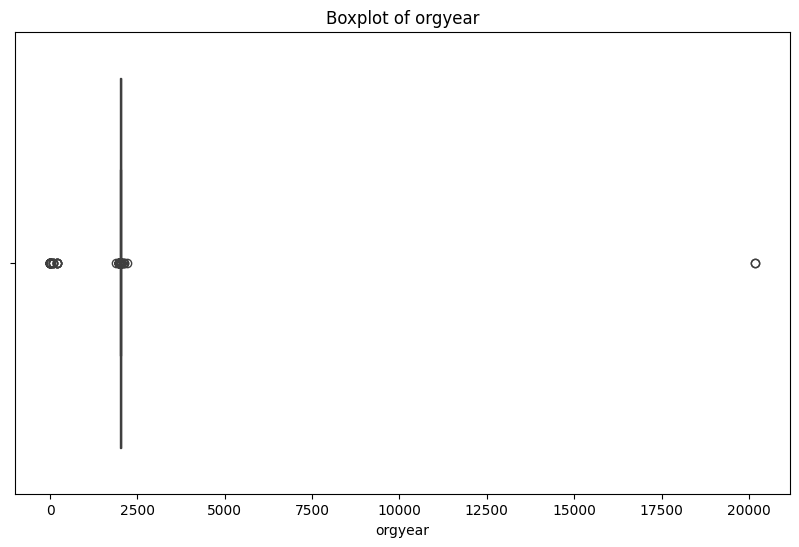

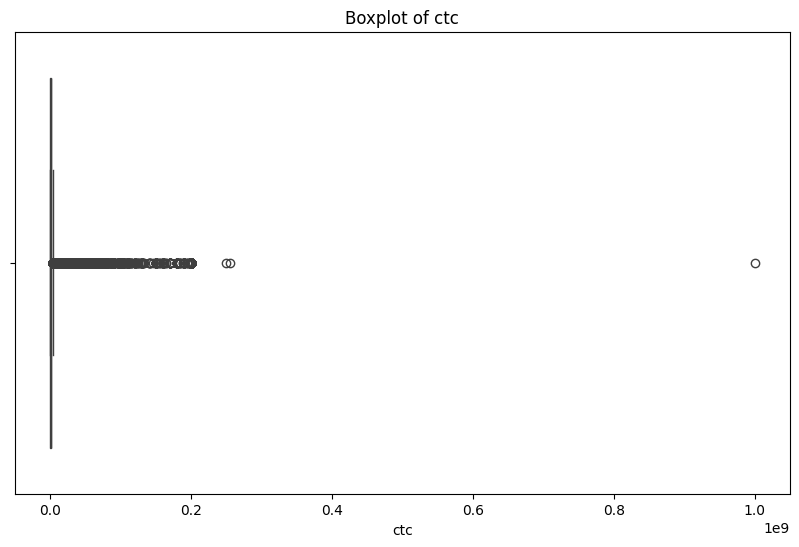

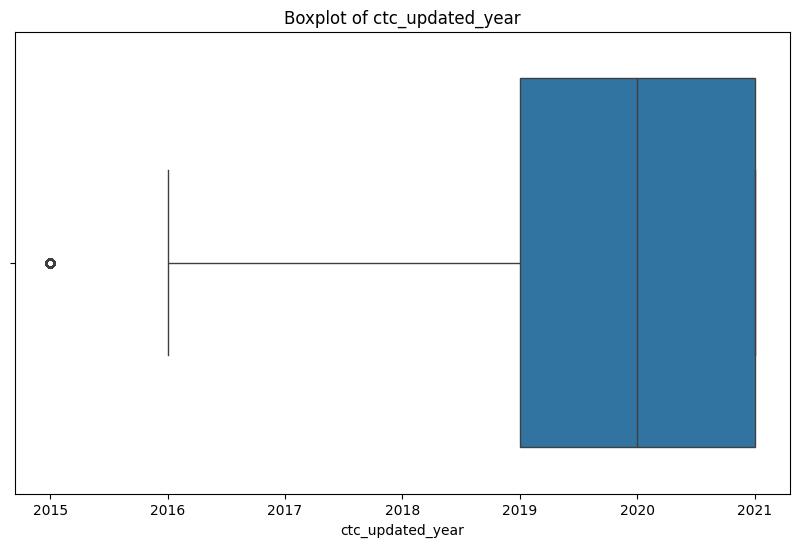

In [ ]:
# Plotting boxplot for Continuous Variables
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def boxplot(df):
  for feature in df.columns:
    # Skipping non-numeric features for histogram plotting
    if df[feature].dtype == 'object':
        continue

    # Create the histogram
    plt.figure(figsize=(10, 6))
    sns.boxplot(data = df, x = feature)

    # Add title and labels
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

    # Show the plot
    plt.show()

boxplot(df.iloc[:,1:])

**Comments:**

- Data has 7 features and 205,843 samples

**Data Cleaning**

1. orgyear and ctc_updated_year to be converted from float to int
2. Data cleaning needs to be performed in orgyear
3. ctc has one major outlier, delete that value.

**Data Pre-processing**
3. "Unnamed : 0" column contains unique id hence can be dropped as it is not needed for analysis
4. 'company_hash', 'email_hash','job_position' have > 1000 unique values hence perform target encoding.
5. NULL values present in company_hash (44), orgyear (86), job_position (52564)


## ***Data Cleaning***

### **Catgorizing columns**

In [ ]:
df.columns

Index(['Unnamed: 0', 'company_hash', 'email_hash', 'orgyear', 'ctc',
       'job_position', 'ctc_updated_year'],
      dtype='object')

In [ ]:
# categorizing columns

todrop = ['Unnamed: 0']

categorical = ['company_hash', 'email_hash','job_position']

continuous = ['orgyear', 'ctc','ctc_updated_year']

cat_to_con = ['company_hash', 'email_hash','job_position']

### **Data Type Conversion**

In [ ]:
# Handling non finite values and converting data type of columns from float to int

#df['orgyear'] = df['orgyear'].fillna(0).astype(int)
df['ctc_updated_year'] = df['ctc_updated_year'].fillna(0).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 11.0+ MB


### **Org_year Data Cleaning**

1. Org year with length not equal to 4 is made 0
2. Encoding

- 1900 > 2000
- 2101 > 2001
- 2106 > 2006
- 2107 > 2007
- 2204 > 2004

In [ ]:
# filter columns with multiple conditions
orgyear = pd.DataFrame(df['orgyear'].value_counts().reset_index())
orgyear.columns = ['orgyear','count']
orgyear[(orgyear['count'] < 8) & (orgyear['orgyear'].astype(str).str.len() != 6)]

,orgyear,count
42,3.0,6
49,91.0,3
50,2.0,3
51,20165.0,2
53,6.0,2
54,5.0,2
55,1.0,2
57,83.0,1
58,209.0,1
62,201.0,1


In [ ]:
# update the incorrect values of orgyear to 0
df.loc[(df['orgyear'].astype(str).str.len() != 6) & (df['orgyear'] != 0), 'orgyear'] = np.nan
df.loc[(df['orgyear'].astype(str).str.len() != 6) & (df['orgyear'] != 0), 'orgyear']

,orgyear
2333,NaN
2562,NaN
3122,NaN
3365,NaN
4010,NaN
...,...
188672,NaN
194087,NaN
196354,NaN
203992,NaN


In [ ]:
# list and count of unique values of org year
df['orgyear'].sort_values().unique()

array([   0., 1900., 1970., 1971., 1972., 1973., 1976., 1977., 1979.,
       1981., 1982., 1984., 1985., 1986., 1987., 1988., 1989., 1990.,
       1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999.,
       2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008.,
       2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017.,
       2018., 2019., 2020., 2021., 2022., 2023., 2024., 2025., 2026.,
       2027., 2028., 2029., 2031., 2101., 2106., 2107., 2204.,   nan])

**Comments:**

For orgyear

- 2025, 2026, 2027, 2028, 2029, 2031 values make no sense as they are in the future
- 2101, 2106, 2107, 2204 values absolutely make no sense as they talk about next century

In [ ]:
# Encoding

df.loc[df['orgyear'] == 1900.0, 'orgyear'] = 2000.0
df.loc[df['orgyear'] == 2101.0, 'orgyear'] = 2001.0
df.loc[df['orgyear'] == 2106.0, 'orgyear'] = 2006.0
df.loc[df['orgyear'] == 2107.0, 'orgyear'] = 2007.0
df.loc[df['orgyear'] == 2204.0, 'orgyear'] = 2004.0
df.loc[df['orgyear'] == 0.0, 'orgyear'] = np.nan
df['orgyear'].sort_values().unique()

array([1970., 1971., 1972., 1973., 1976., 1977., 1979., 1981., 1982.,
       1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992.,
       1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001.,
       2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
       2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.,
       2020., 2021., 2022., 2023., 2024., 2025., 2026., 2027., 2028.,
       2029., 2031.,   nan])

### **Removing outlier in CTC**

In [ ]:
print(df.shape)
df.drop(df.loc[df['ctc'] == 1000150000].index, inplace = True)
print(df.shape)

(205843, 7)
(205842, 7)


### **Plotting CTC with baskets**

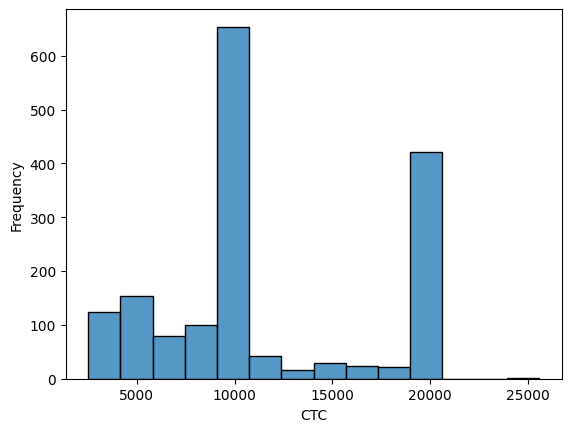

In [ ]:
# Hist plot of CTC > 250000000 (25 CR)
df_plot = df.copy()

def func(x):
  return x/10000

df_plot['ctc'] = df['ctc'].apply(func)

df_plt = df_plot.loc[(df_plot['ctc'] < 200000000) & (df_plot['ctc'] > 2500)]

sns.histplot(df_plt, x = 'ctc')
plt.xlabel('CTC')
plt.ylabel('Frequency')
plt.show()

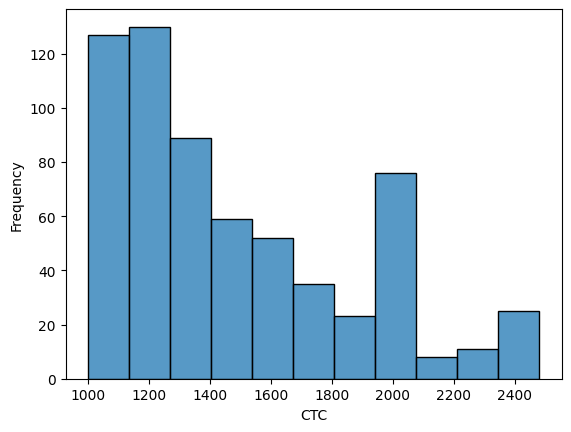

In [ ]:
# Hist plot of CTC between 100000000 (10 CR) and 250000000 (25 CR)
df_plot = df.copy()

def func(x):
  return x/10000

df_plot['ctc'] = df['ctc'].apply(func)

df_plt = df_plot.loc[(df_plot['ctc'] < 2500) & (df_plot['ctc'] > 1000)]

sns.histplot(df_plt, x = 'ctc')
plt.xlabel('CTC')
plt.ylabel('Frequency')
plt.show()

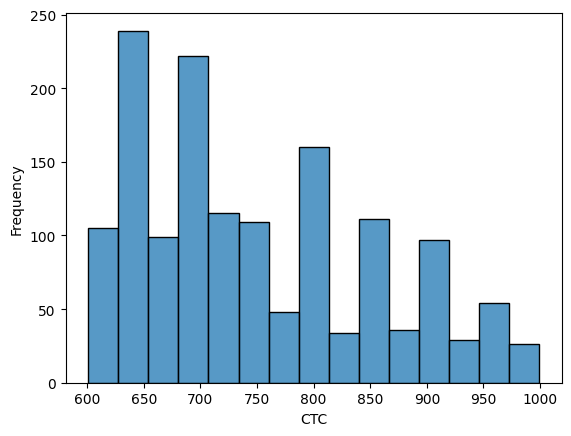

In [ ]:
# Hist plot of CTC between 60000000 (6 CR) and 100000000 (10 CR)
df_plot = df.copy()

def func(x):
  return x/10000

df_plot['ctc'] = df['ctc'].apply(func)

df_plt = df_plot.loc[(df_plot['ctc'] < 1000) & (df_plot['ctc'] > 600)]

sns.histplot(df_plt, x = 'ctc')
plt.xlabel('CTC')
plt.ylabel('Frequency')
plt.show()

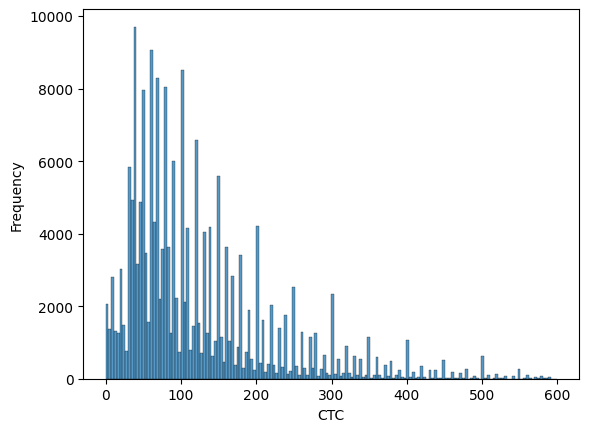

In [ ]:
# Hist plot of CTC between 60000000 (6 CR) and 100000000 (10 CR)
df_plot = df.copy()

def func(x):
  return x/10000

df_plot['ctc'] = df['ctc'].apply(func)

df_plt = df_plot.loc[(df_plot['ctc'] < 600) & (df_plot['ctc'] > 0)]

sns.histplot(df_plt, x = 'ctc')
plt.xlabel('CTC')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df_plot.loc[df['ctc'] > 200000000]

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
3301,3301,aveegaxr xzntqzvnxgzvr hzxctqoxnj,06d231f167701592a69cdd7d5c825a0f5b30f0347a4078...,2021.0,25000.0000,NaN,2020
117636,117948,obvqnuqxdwgb,5b4bed51797140db4ed52018a979db1e34cee49e27b488...,2018.0,25555.5555,NaN,2016


In [ ]:
df.loc[df['ctc'] > 200000000]

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
3301,3301,aveegaxr xzntqzvnxgzvr hzxctqoxnj,06d231f167701592a69cdd7d5c825a0f5b30f0347a4078...,2021.0,250000000,NaN,2020
117636,117948,obvqnuqxdwgb,5b4bed51797140db4ed52018a979db1e34cee49e27b488...,2018.0,255555555,NaN,2016


**Comments:**

There may have been extra zeros added at the end of CTC, ignoring those for now.

# ***2. Data Pre-processing***

***'CTC', 'Job_position', and 'orgyear' play vital roles in clustering.***


1. Drop Unnamed column
2. Check and remove duplicates in the data
3. Remove special characters from categorical columns using Regex

4. Cat to Con conversion
- company_hash
- email_hash
- job_position
</br>

5. Null value treatment (KNN Imputation)
- company_hash  (categorical)
- orgyear
- job_position  (categorical)


In [ ]:
# Check for duplicate values in dataset after removing unnamed column
df.iloc[:,1:].duplicated().value_counts()

,count
False,205808
True,34


In [ ]:
# Null values in the DataFrame
df.isna().sum()

,0
Unnamed: 0,0
company_hash,44
email_hash,0
orgyear,131
ctc,0
job_position,52563
ctc_updated_year,0


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def pre_processing(df, todrop, categorical, continuous, cat_to_con):
  '''
  Description: This function return processed data for analysis

  Parameters:
  todrop: columns to be dropped from the dataframe
  categorical: categorical columns
  continuous: continuous columns
  cat_to_con: categorical columns to be converted to continuous using encoding

  Results:
  df_transformed: processed dataframe for analysis
  '''

  print("Null values before processing:", df.isna().sum().sum())
  print("-"*20)

  # 1. dropping columns not needed for analysis
  df = df.drop(columns = todrop)

  # 2. remove duplicate values from dataset
  df.drop_duplicates(keep = 'first', inplace = True)
  print("No. of duplicates in dataset:",df.duplicated().value_counts())
  print("-"*20)

  # 3. remove special characters from categorical columns using Regex
  for col in categorical:
      df[col] = df[col].astype(str).apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x))

  # 5. categorical NULL values updated to NA
  logical_nans = categorical
  for col in logical_nans:
      df[col] = df[col].fillna('NA')
  print("No. of nan's in categorical cols:", df[categorical].isna().sum().sum())

  # 5. Null value treatment using KNN Imputation for numerical columns

  # Create the pipeline
  pipeline = Pipeline([
    #('scaler', StandardScaler()),           # Step 1: StandardScaler for feature scaling
    ('imputer', KNNImputer(n_neighbors=5))  # Step 2: KNNImputer for missing value imputation
    ])

  # Fit and transform the data using the pipeline
  df_transformed = pipeline.fit_transform(df[['orgyear']])

  # Creating dataframe
  df_transformed = pd.DataFrame(df_transformed, columns = ['orgyear'])
  df['orgyear'] = df_transformed['orgyear']

  print("-"*20)
  print("Null values after processing:", df.isnull().sum().sum())
  print("-"*20)
  print("Shape of processed data:", df.shape)
  print("-"*20)
  return df

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def encoding(df, todrop, categorical, continuous, cat_to_con):
  '''
  Description: This function return processed data for analysis

  Parameters:
  todrop: columns to be dropped from the dataframe
  categorical: categorical columns
  continuous: continuous columns
  cat_to_con: categorical columns to be converted to continuous using encoding

  Results:
  df_transformed: processed dataframe for analysis
  '''
  # 4. cat_to_con conversion target encoding
  target = 'ctc'
  for col in cat_to_con:
      df[col] = df.groupby([col])[target].transform('mean')

  return df

In [ ]:
# performing data pre-processing
df_processed = pre_processing(df, todrop, categorical, continuous, cat_to_con)

Null values before processing: 52738
--------------------
No. of duplicates in dataset: False    205808
Name: count, dtype: int64
--------------------
No. of nan's in categorical cols: 0
--------------------
Null values after processing: 35
--------------------
Shape of processed data: (205808, 6)
--------------------


## **Handling unhandled NaN values**

In [ ]:
# making unhandled NaN values with current year
df_processed['orgyear'] = df_processed['orgyear'].fillna(2024)
df_processed.isnull().sum()

,0
company_hash,0
email_hash,0
orgyear,0
ctc,0
job_position,0
ctc_updated_year,0


## **Data Type Conversion**

In [ ]:
# converting orgyear to int
df_processed['orgyear'] = df_processed['orgyear'].astype(int)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205808 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   company_hash      205808 non-null  object
 1   email_hash        205808 non-null  object
 2   orgyear           205808 non-null  int64 
 3   ctc               205808 non-null  int64 
 4   job_position      205808 non-null  object
 5   ctc_updated_year  205808 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 11.0+ MB


## **Feature Engineering**

In [ ]:
# creating a deep copy of processed data
df1 = df_processed.copy()

In [ ]:
df1['Current year'] = 2024
df1['Years of Experience'] = df1['Current year'] - df1['orgyear']
df1.head(2)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Current year,Years of Experience
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,2024,8
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019,2024,6


In [ ]:
df1['Years to ctc update'] = df1['Current year'] - df1['ctc_updated_year']
df1.head(2)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Current year,Years of Experience,Years to ctc update
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,2024,8,4
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019,2024,6,5


## **Updating CTC Correctly**

In [ ]:
# students with no experience should have ctc = 0
df1.loc[df1['Years of Experience'] < 0, 'ctc'] = 0
df1.loc[df1['Years of Experience'] < 0, 'ctc'].head()

,ctc
2211,0
10076,0
11081,0
19920,0
19937,0


In [ ]:
# students with no experience should have Years or Experience = 0
df1.loc[df1['Years of Experience'] < 0, 'Years of Experience'] = 0
df1.loc[df1['Years of Experience'] < 0, 'Years of Experience'].head()

,Years of Experience


# ***1. Exploratory Data Analysis (Graphical)***

In [ ]:
# deep copy

df2 = df1.copy()   # not encoded
df3 = df1.copy()   # encoded

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def encoding(df, todrop, categorical, continuous, cat_to_con):
  '''
  Description: This function return processed data for analysis

  Parameters:
  todrop: columns to be dropped from the dataframe
  categorical: categorical columns
  continuous: continuous columns
  cat_to_con: categorical columns to be converted to continuous using encoding

  Results:
  df_transformed: processed dataframe for analysis
  '''
  # 4. cat_to_con conversion target encoding
  target = 'ctc'
  for col in cat_to_con:
      df[col] = df.groupby([col])[target].transform('mean')

  return df

df_encoded = encoding(df3, todrop, categorical, continuous, cat_to_con)

## **Univariate analysis**

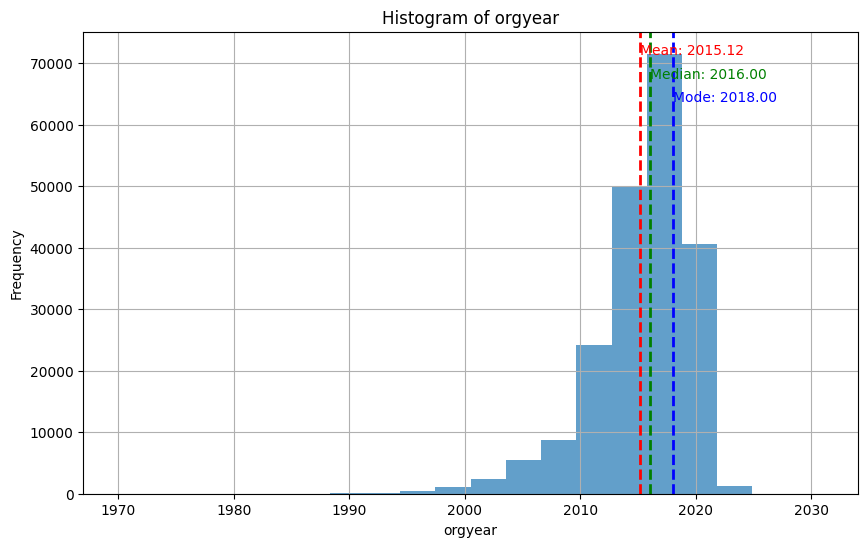

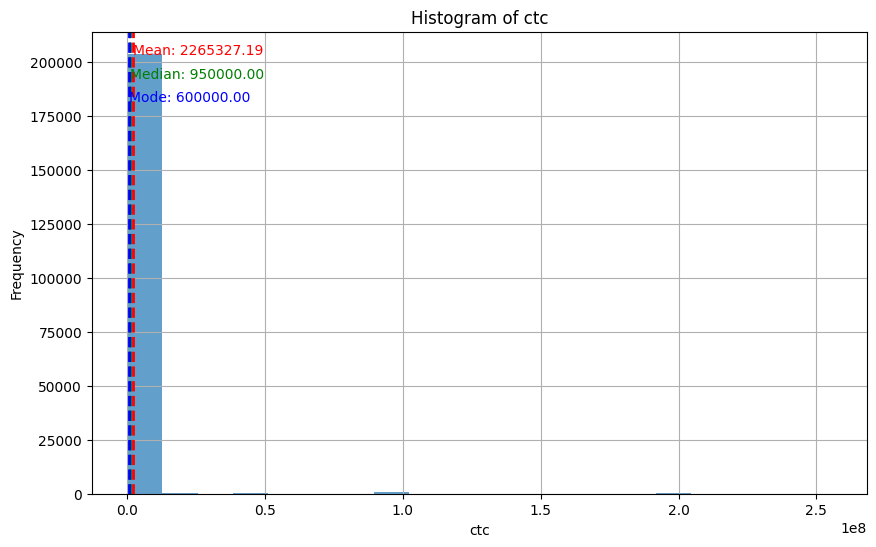

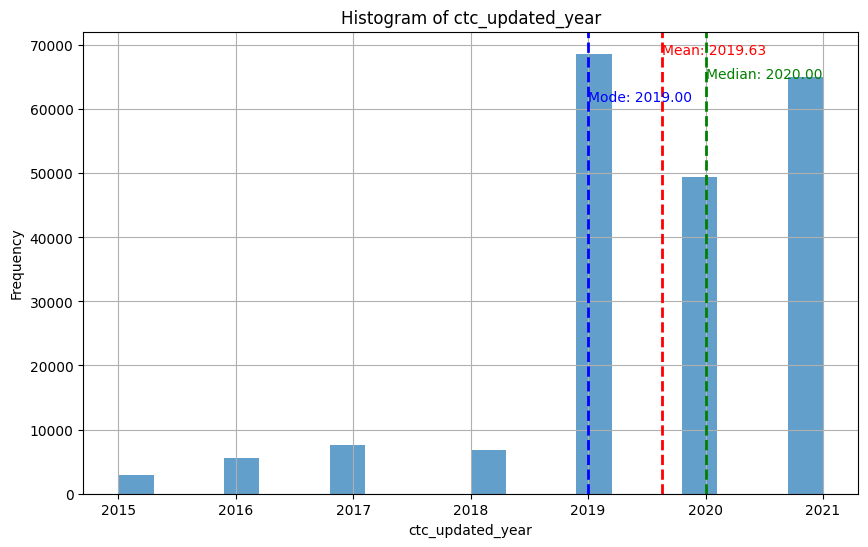

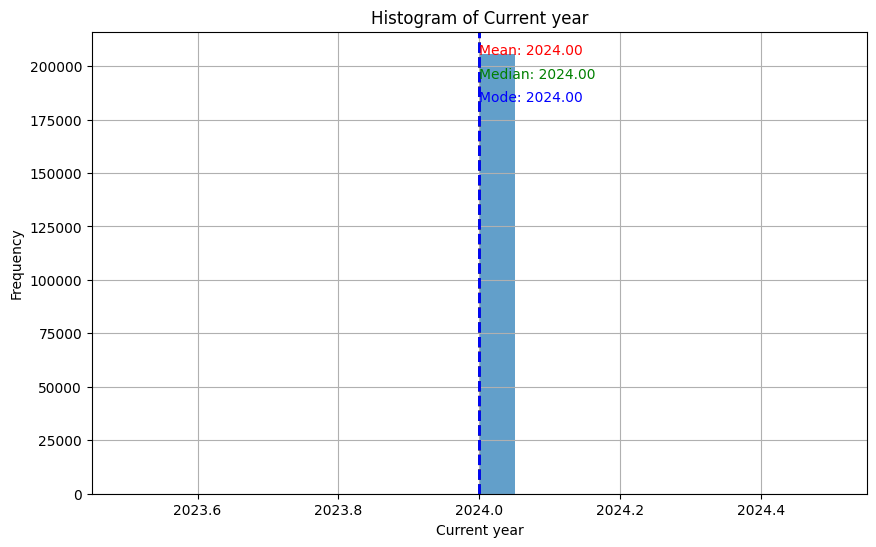

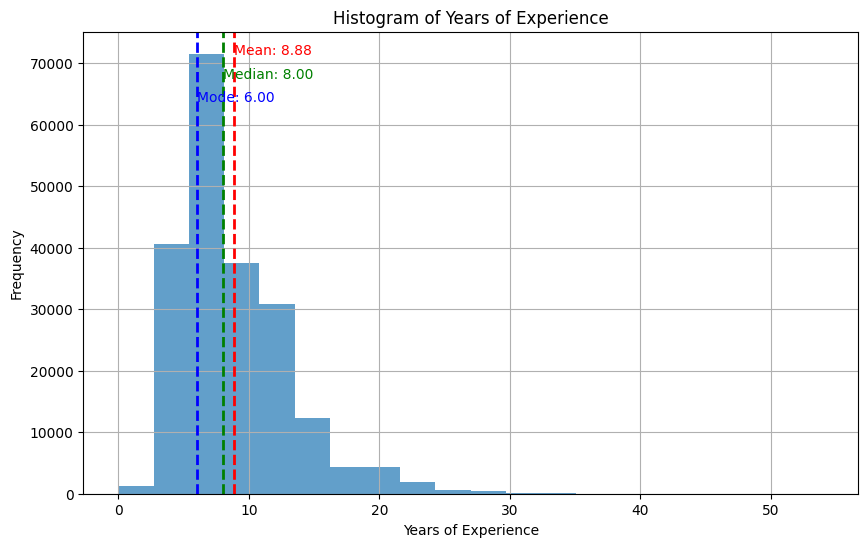

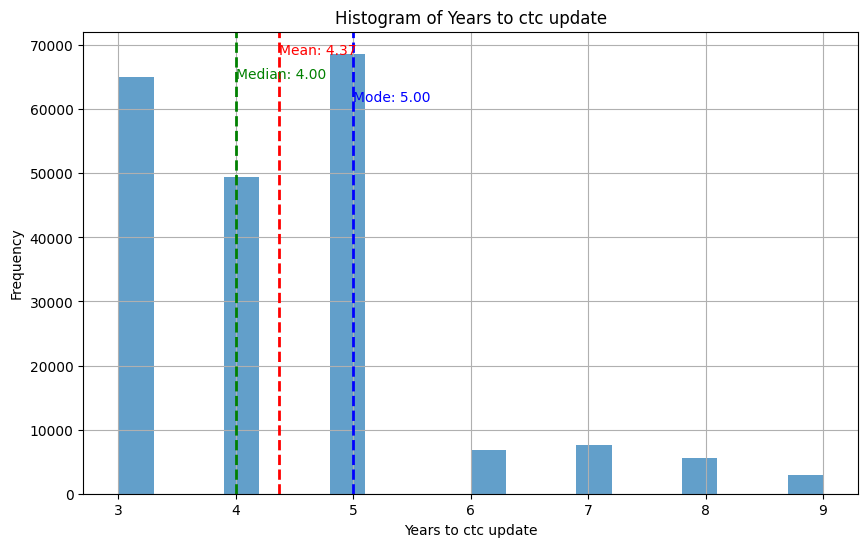

In [ ]:
# Plotting Histogram for Continuous Variables
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def histplot(df):
  for feature in df.columns:
    # Skipping non-numeric features for histogram plotting
    if df[feature].dtype == 'object':
        continue

    # Calculate mean, median, and mode
    mean = df[feature].mean()  # Fill in the blank to calculate mean
    median = df[feature].median()  # Fill in the blank to calculate median
    mode = df[feature].mode().get(0, np.nan)  # Fill in the blank to calculate mode

    # Create the histogram
    plt.figure(figsize=(10, 6))
    df[feature].hist(bins=20, alpha=0.7)

    # Add lines for mean, median, and mode
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)  # Fill in the blank to plot mean
    plt.axvline(median, color='green', linestyle='dashed', linewidth=2)  # Fill in the blank to plot median
    plt.axvline(mode, color='blue', linestyle='dashed', linewidth=2)  # Fill in the blank to plot mode

    # Add annotations for mean, median, and mode
    plt.text(mean, plt.ylim()[1] * 0.95, f'Mean: {mean:.2f}', color = 'red')  # Fill in the blank to annotate mean
    plt.text(median, plt.ylim()[1] * 0.90, f'Median: {median:.2f}', color = 'green')  # Fill in the blank to annotate median
    plt.text(mode, plt.ylim()[1] * 0.85, f'Mode: {mode:.2f}', color = 'blue')  # Fill in the blank to annotate mode

    # Add title and labels
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

histplot(df1)

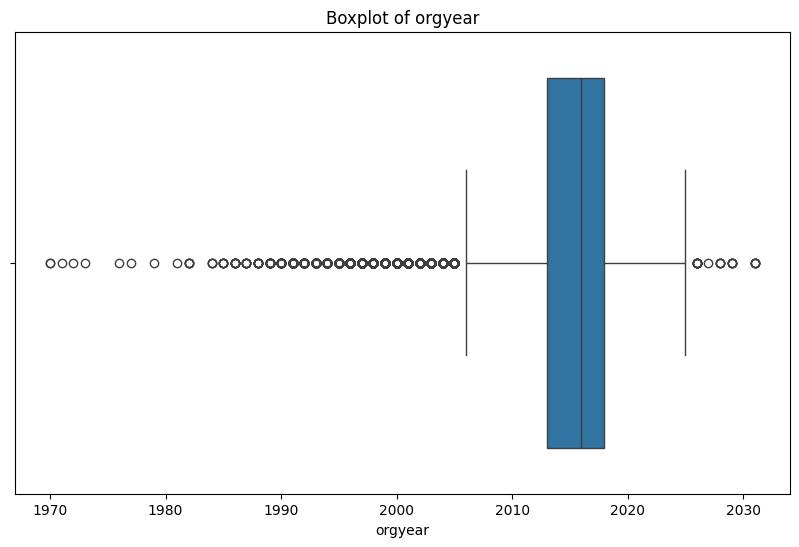

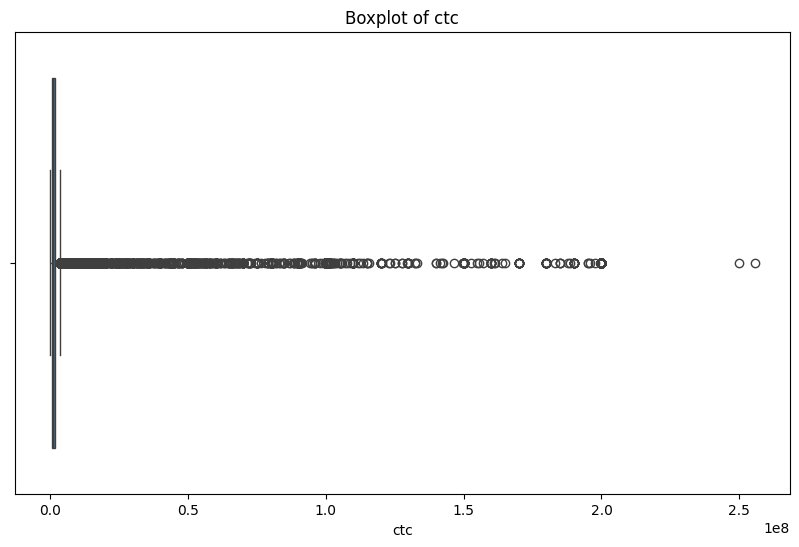

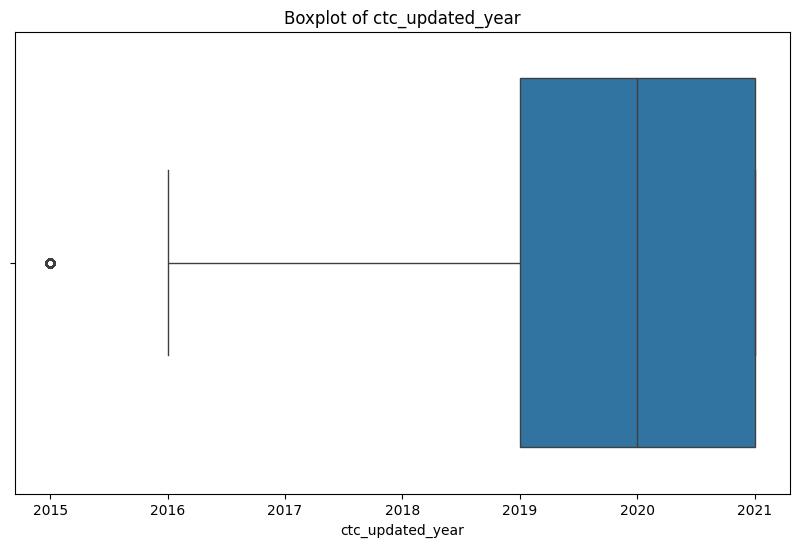

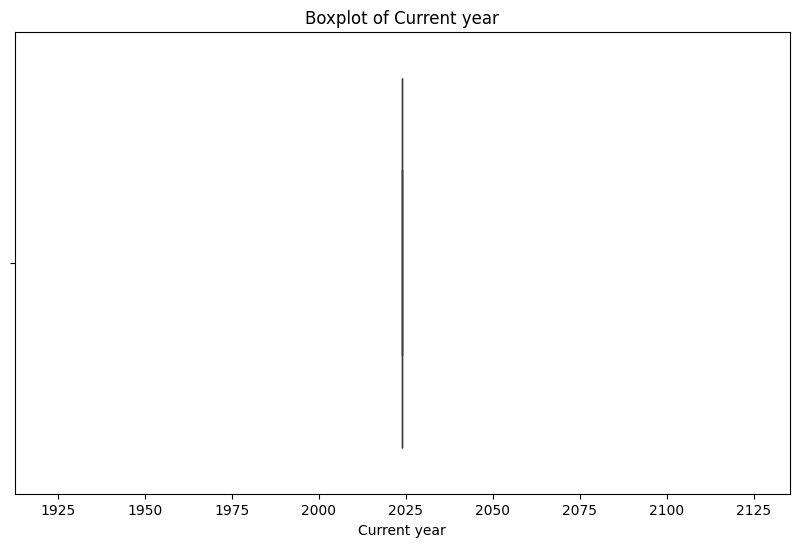

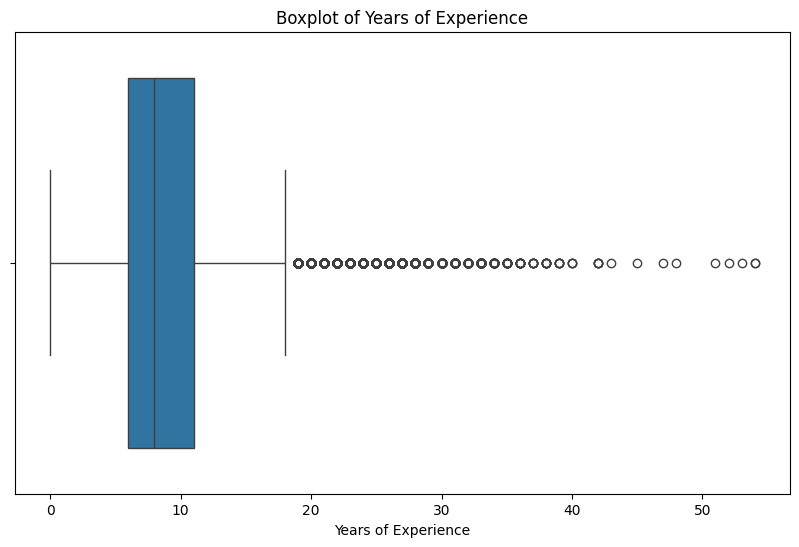

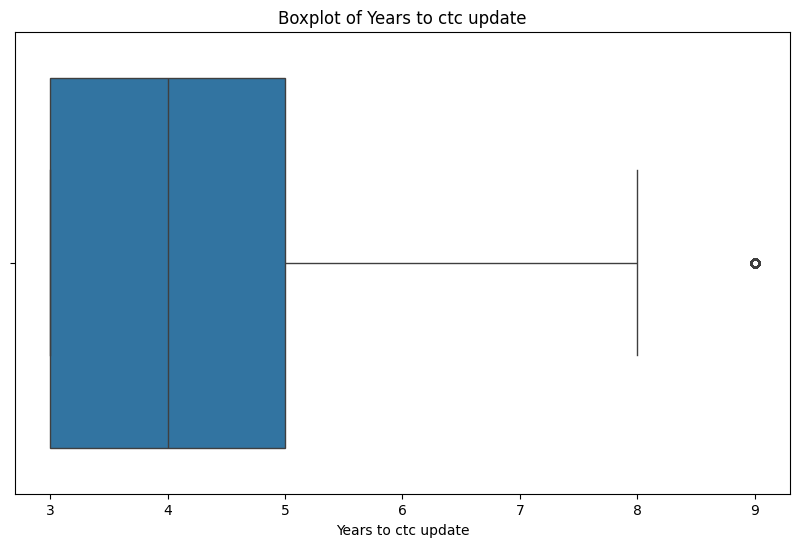

In [ ]:
# Plotting boxplot for Continuous Variables
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def boxplot(df):
  for feature in df.columns:
    # Skipping non-numeric features for histogram plotting
    if df[feature].dtype == 'object':
        continue

    # Create the histogram
    plt.figure(figsize=(10, 6))
    sns.boxplot(data = df, x = feature)

    # Add title and labels
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

    # Show the plot
    plt.show()

boxplot(df1)

**Comments: Univariate analysis**

- Data for orgyear appears to be left skewed with mean at 2015 and median at 2016.
- Mean CTC is 2271k, median is 950k, mode is 600k: There are definitely outliers here.
- Most ctcs were updated in year 2019 (mode), Mean is 2019 and median is 2020.
- Years of experience is right skewed with mean 8.88, median 8.0, mode 6.0
- Years to ctc update falls mainly between 3 to 5 with mean 4.37, median 4, mode 5.

Almost all variables have outliers, ctc has one major outlier.

## **Bivariate / Multi-variate analysis**


Boxplot for categorical continuous
crosstab for categorical categorical

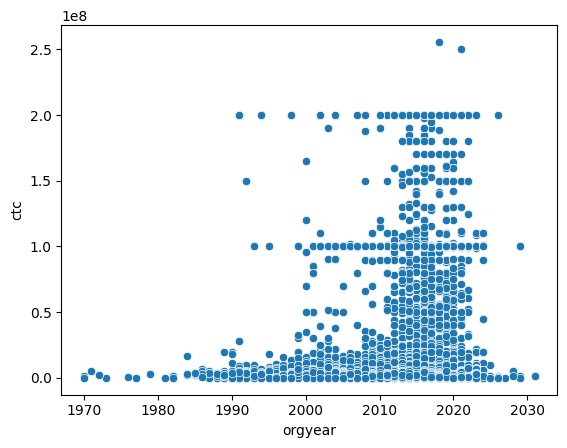

In [ ]:
# Scatterplot for ctc and org_year
sns.scatterplot(data = df, y = 'ctc', x = 'orgyear')
plt.show()

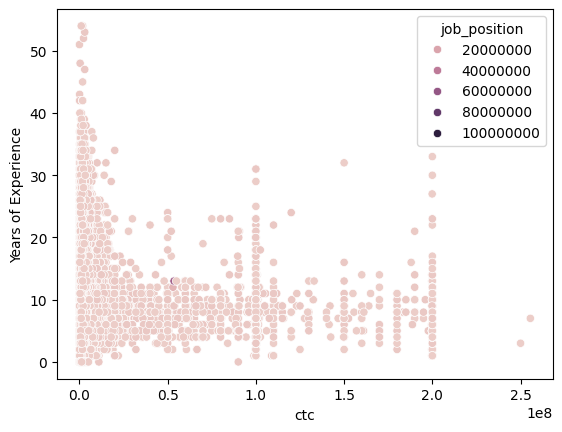

In [ ]:
sns.scatterplot(df_encoded, x = 'ctc', y = 'Years of Experience', hue = 'job_position')
plt.show()

In [ ]:
df1['ctc'].min(), df1['ctc'].max()

(0, 255555555)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


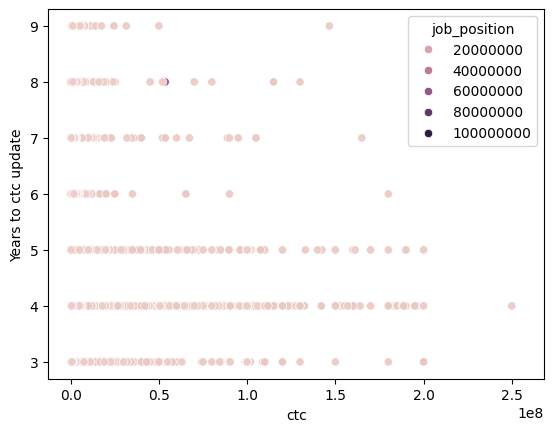

In [ ]:
sns.scatterplot(data = df_encoded, x = 'ctc', y = 'Years to ctc update', hue = 'job_position')
plt.show()

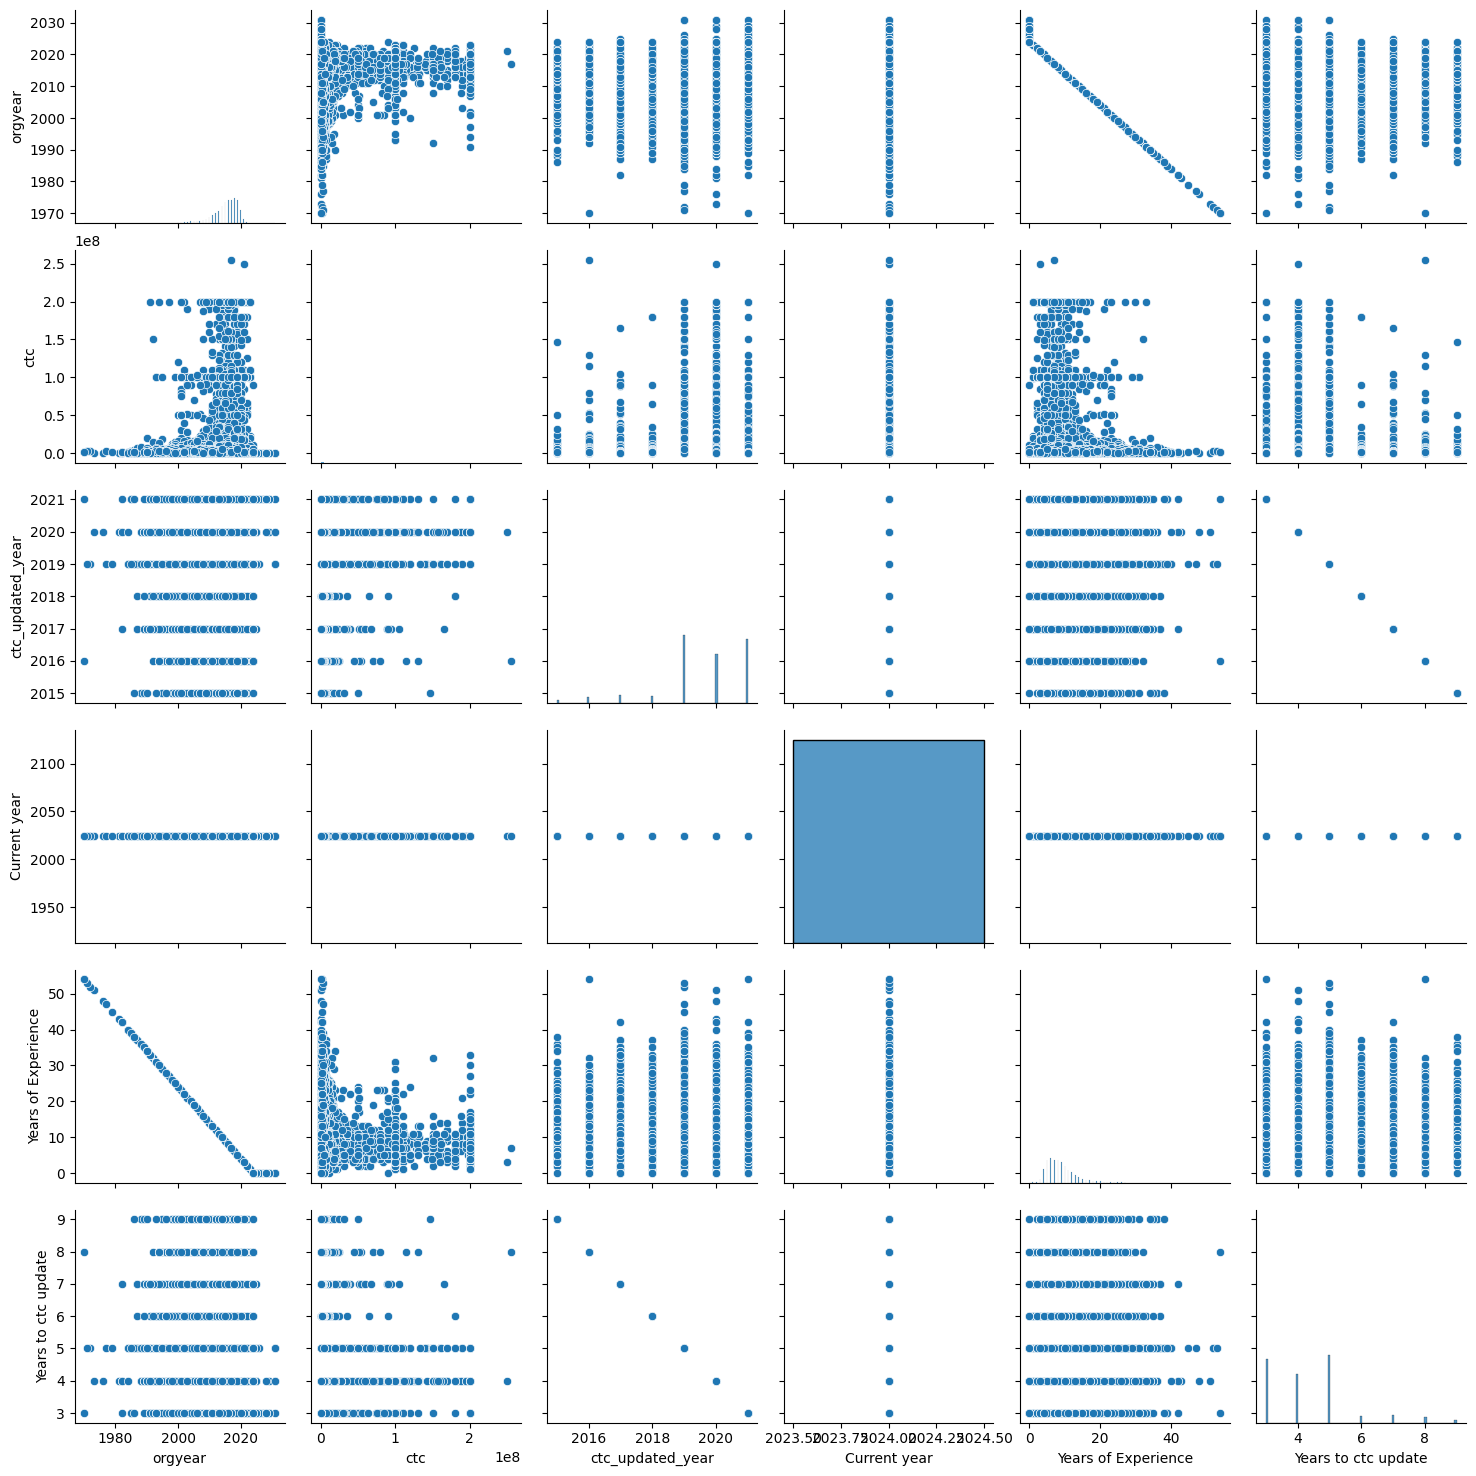

In [ ]:
# pairplot
sns.pairplot(data = df1)
plt.show()

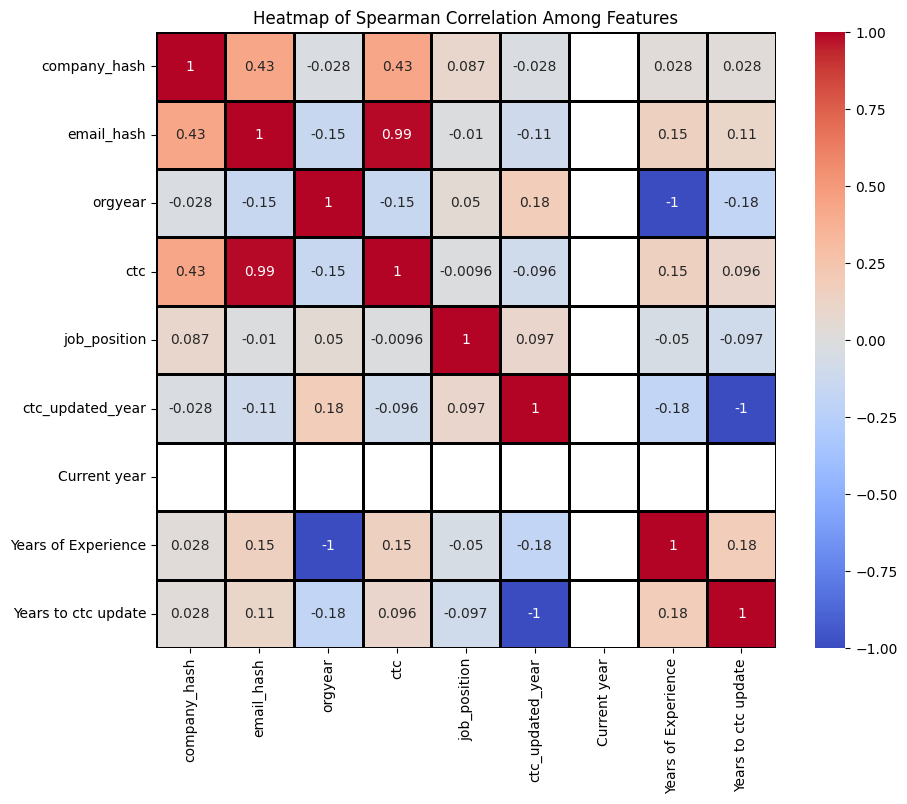

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating spearman's correlation b/w all the features - to check non-linear correlation b/w the features

# Compute the correlation matrix for the selected features
correlation_matrix = df_encoded.corr(method="spearman")

correlation_matrix

plt.figure(figsize=(10, 8))
# TODO: Fill in the appropriate variable to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=2, linecolor='black')
plt.title('Heatmap of Spearman Correlation Among Features')
plt.show()

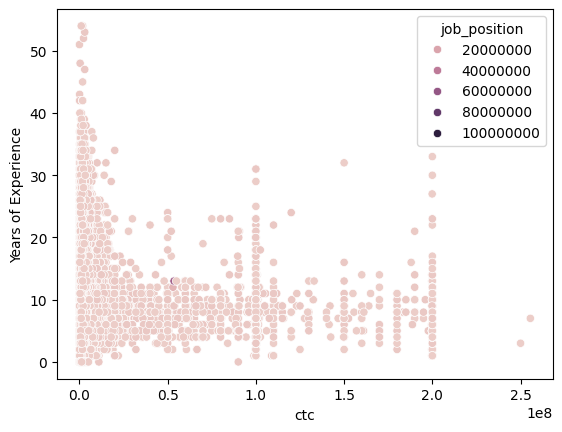

In [ ]:
# Scatter plot of CTC & Years of Experience
sns.scatterplot(df_encoded, x = 'ctc', y = 'Years of Experience', hue = 'job_position')
plt.show()

**Comments: Multi variate analysis**

From heatmap,
- company_hash and email_hash have positive correlation of 0.43
- Years of Experience has 0.19 positive correlation with email_hash, ctc, years to ctc update.
- Years of Experience and ctc_updated_year has negative 0.19 correlation.
- ctc and orgyear have negative 0.19 correlation
- ctc has -0.096 with ctc_updated_year and 0.096 with Years to ctc update

From pairplot,
- CTC & Years of Experience / orgyear form a cluster
- Job position and Years of Experience / orgyear form clusters
- There appears to be some outlier

**Insights:**

Histogram:
- Most students have employment start date mean of 2015 and mode of 2018
- Most students have package around 600,000
- Most students have ctc_year_updated in 2019

Scatter plot:
- Scatter plot of ctc & orgyear reveals, **students with latest orgyear have higher ctc.**
- Scatter plot of ctc and years of experience reveals, **ctc is high for students with years of experience < 30 years.**
- **Students with more than 25 years of experience have lower salaries.**
- **CTC is higher for students whose ctc is updated within 3 to 5 years.** Students whose ctc is updated more than 5 years back have low ctc.

# ***3. Model building***

**3. Manual Clustering: (30 Points)**
- Creating Designation Flag & Insights
- Creating Class Flag & Insights
- Creating Tier Flag & Insights

## **Data Preparation for Modelling**

### **Data Splitting**

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test = train_test_split(df_encoded,test_size=0.20,random_state=0)

print(X_train.shape, X_test.shape)

(164646, 9) (41162, 9)


### **Standardizing Data**

In [ ]:
# Standardizing data

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_train)
df_scaled = pd.DataFrame(df_scaled, columns=df2.columns)

### **Outliers Detection**

#### **Dimensionality Reduction - Visualize**

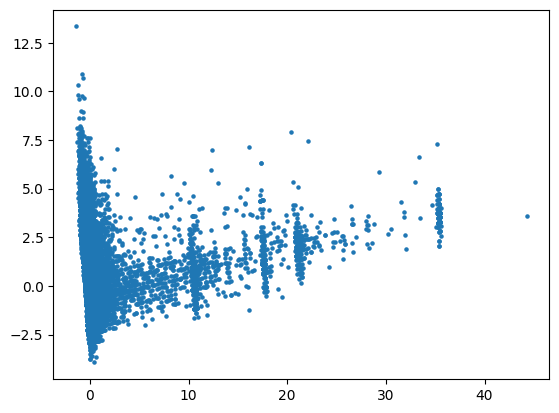

In [ ]:
# PCA to visualize data
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
vis = pca.fit_transform(df_scaled)
plt.scatter(vis[:, 0], vis[:, 1], s = 5)    # s -> Size of marker, c -> color of marker
plt.show()

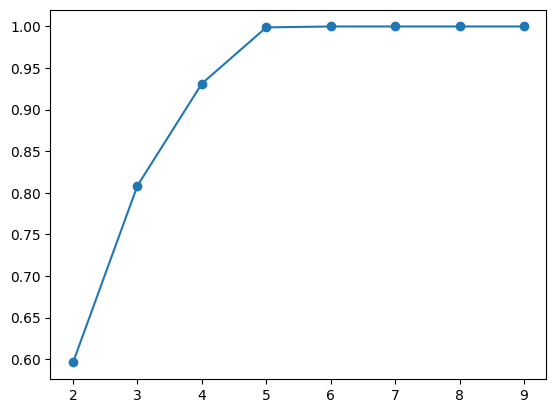

In [ ]:
# Hyper parameter tuning PCA to identify best number of components
from sklearn.decomposition import PCA

cs = [2,3,4,5,6,7,8,9]
info = []
for i in cs:
  pca = PCA(n_components=i)
  pca.fit(df_scaled)
  info.append(pca.explained_variance_ratio_.sum())

plt.plot(cs, info, '-o')
plt.show()

**Comments:**

- Just by retaining 5 features we are able to explain 100% of the data

In [ ]:
# TSNE to visualize data better
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, random_state=0)
#vis = tsne.fit_transform(df_scaled)
#plt.scatter(vis[:,0], vis[:,1], s=5)
#plt.show()

In [ ]:
!pip install umap-learn
from umap import UMAP

In [ ]:
# UMAP to check if we can obtain better visualization
from umap import UMAP

#umap = UMAP(n_components=2, random_state=0)    # init='random'
#vis_umap = umap.fit_transform(df_scaled)
#plt.scatter(vis_umap[:,0], vis_umap[:,1], s=5)
#plt.show()

#### **Outlier Detection: Isolation Forest**

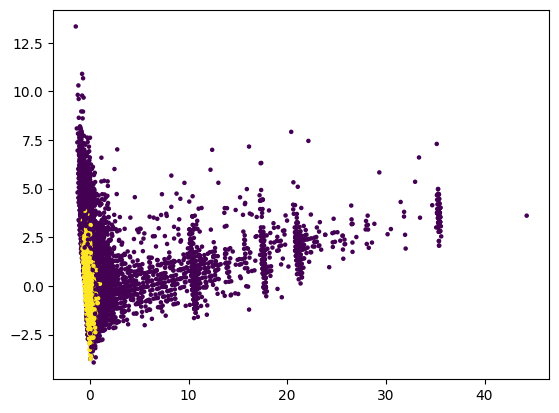

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

is_outlier = IsolationForest(contamination=0.15, random_state=0,
                            n_estimators=1000).fit_predict(vis)
plt.scatter(vis[:, 0], vis[:, 1], s=5, c=is_outlier)
plt.show()

#### **Outlier Detection: LOF (Local Outlier Factor)**

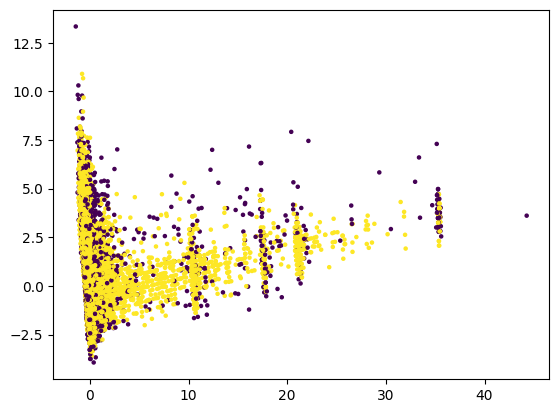

In [ ]:
is_outlier = LocalOutlierFactor(contamination=0.15, n_neighbors=5).fit_predict(vis)
plt.scatter(vis[:, 0], vis[:, 1], s=5, c=is_outlier)
plt.show()

## ***Manual Clustering***

Manual Clustering on the basis of learner’s company, job position and years of experience
1. Getting the 5 point summary of CTC (mean, median, max, min, count etc) on the basis of Company, Job Position, Years of Experience
2. Merging the same with original dataset carefully and creating some flags showing learners with CTC greater than the Average of their Company’s department having same Years of Experience - Call that flag designation with values [1,2,3]
3. Doing above analysis at Company & Job Position level. Name that flag Class with values [1,2,3]
4. Repeating the same analysis at the Company level. Name that flag Tier with values [1,2,3]

CTC > average: Class 1
CTC = average: Class 2
CTC < average: Class 3

In [ ]:
# 5 point summary of CTC based on Company and Years of Experience
df2.groupby(['company_hash','Years of Experience'])['ctc'].mean()

company_hash                    Years of Experience
0                               4                       100000.0
0000                            6                       300000.0
01 ojztqsj                      10                      270000.0
                                13                      830000.0
05mz exzytvrny uqxcvnt rxbxnta  6                      1100000.0
                                                         ...    
zz                              15                      500000.0
zzb ztdnstz vacxogqj ucn rna    6                       600000.0
                                7                       600000.0
zzgato                          12                      130000.0
zzzbzb                          34                      720000.0
Name: ctc, Length: 75090, dtype: float64

In [ ]:
# destination flag creation of CTC based on Company and Years of Experience
df2['mean_ctc_1'] = df2.groupby(['company_hash','Years of Experience'])['ctc'].transform('mean')
df2['designation_flag'] = np.where(df2['ctc'] > df2['mean_ctc_1'], 1, np.where(df2['ctc'] == df2['mean_ctc_1'], 2, 3))
df2.head(2)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Current year,Years of Experience,Years to ctc update,mean_ctc_1,designation_flag
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,2024,8,4,1.100000e+06,2
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019,2024,6,5,8.381764e+05,3


In [ ]:
# 5 point summary of CTC based on Company and Job Position
df2.groupby(['company_hash','job_position'])['ctc'].mean()

company_hash                  job_position      
0                             Other                 100000.0
                              nan                   100000.0
0000                          Other                 300000.0
01 ojztqsj                    Android Engineer      270000.0
                              Frontend Engineer     830000.0
                                                      ...   
zz                            nan                   500000.0
zzb ztdnstz vacxogqj ucn rna  FullStack Engineer    600000.0
                              nan                   600000.0
zzgato                        nan                   130000.0
zzzbzb                        Other                 720000.0
Name: ctc, Length: 71297, dtype: float64

In [ ]:
# Flag creation of CTC based on Company and Job Position
df2['mean_ctc_2'] = df2.groupby(['company_hash','job_position'])['ctc'].transform('mean')
df2['class_flag'] = np.where(df2['ctc'] > df2['mean_ctc_2'], 1, np.where(df2['ctc'] == df2['mean_ctc_2'], 2, 3))
df2.head(2)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Current year,Years of Experience,Years to ctc update,mean_ctc_1,designation_flag,mean_ctc_2,class_flag
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,2024,8,4,1.100000e+06,2,1.085000e+06,1
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019,2024,6,5,8.381764e+05,3,9.511363e+05,3


In [ ]:
# 5 point summary of CTC based on Company
df2.groupby(['company_hash'])['ctc'].describe()

,count,mean,std,min,25%,50%,75%,max
company_hash,,,,,,,,
0,2.0,100000.0,0.000000,100000.0,100000.0,100000.0,100000.0,100000.0
0000,1.0,300000.0,NaN,300000.0,300000.0,300000.0,300000.0,300000.0
01 ojztqsj,2.0,550000.0,395979.797464,270000.0,410000.0,550000.0,690000.0,830000.0
05mz exzytvrny uqxcvnt rxbxnta,2.0,1100000.0,0.000000,1100000.0,1100000.0,1100000.0,1100000.0,1100000.0
1,2.0,175000.0,106066.017178,100000.0,137500.0,175000.0,212500.0,250000.0
...,...,...,...,...,...,...,...,...
zyvzwt wgzohrnxzs tzsxzttqo,1.0,940000.0,NaN,940000.0,940000.0,940000.0,940000.0,940000.0
zz,2.0,935000.0,615182.899632,500000.0,717500.0,935000.0,1152500.0,1370000.0
zzb ztdnstz vacxogqj ucn rna,2.0,600000.0,0.000000,600000.0,600000.0,600000.0,600000.0,600000.0


In [ ]:
# Flag creation of CTC based on Company
df2['mean_ctc_3'] = df2.groupby(['company_hash'])['ctc'].transform('mean')
df2['tier_flag'] = np.where(df2['ctc'] > df2['mean_ctc_3'], 1, np.where(df2['ctc'] == df2['mean_ctc_3'], 2, 3))
df2.head(2)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Current year,Years of Experience,Years to ctc update,mean_ctc_1,designation_flag,mean_ctc_2,class_flag,mean_ctc_3,tier_flag
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,2024,8,4,1.100000e+06,2,1.085000e+06,1,1.115667e+06,3
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019,2024,6,5,8.381764e+05,3,9.511363e+05,3,2.193027e+06,3


In [ ]:
df_m = df2[['company_hash','job_position','Years of Experience', 'Years to ctc update','ctc','designation_flag','class_flag','tier_flag']].copy()
df_m.head(2)

,company_hash,job_position,Years of Experience,Years to ctc update,ctc,designation_flag,class_flag,tier_flag
0,atrgxnnt xzaxv,Other,8,4,1100000,2,1,3
1,qtrxvzwt xzegwgbb rxbxnta,FullStack Engineer,6,5,449999,3,3,3


### **Insights**

Based on the manual clustering done so far.

In [ ]:
# Top 10 employees (earning more than most of the employees in the company) - Tier 1
df_m[df_m['tier_flag'] == 1].sort_values(by = 'ctc', ascending=False).head(10)

# Note that 3 highest CTCs have been removed from the data to remove outliers disrupting visualization

,company_hash,job_position,Years of Experience,Years to ctc update,ctc,designation_flag,class_flag,tier_flag
117636,obvqnuqxdwgb,nan,7,8,255555555,2,1,1
45759,otre tburgjta,Other,7,4,200000000,1,1,1
88260,wgzwtznqxd,nan,7,4,200000000,1,1,1
23537,gnytq,Frontend Engineer,8,4,200000000,1,1,1
23186,ouqxzprq,Devops Engineer,12,4,200000000,1,1,1
49046,cxcg,Android Engineer,6,4,200000000,1,2,1
23132,nvnv sqghu,Other,11,4,200000000,2,2,1
88232,gnytqo,Product Manager,9,4,200000000,1,2,1
3471,zgn fgqpxzs,Other,5,4,200000000,1,1,1
23088,ovrtoegqwt,Engineering Leadership,11,4,200000000,1,1,1


In [ ]:
# Top 10 employees of data science in each company earning more than their peers - Class 1
df_m[(df_m['job_position'] == 'Data Scientist') & (df_m['class_flag'] == 1)].sort_values(by = 'ctc', ascending=False).head(10)

,company_hash,job_position,Years of Experience,Years to ctc update,ctc,designation_flag,class_flag,tier_flag
31297,ihvaqvnxw xzoxsyno ucn rna,Data Scientist,9,5,200000000,1,1,1
52818,zgzt,Data Scientist,2,4,200000000,1,1,1
836,mqxonrtwgzt v bvyxzaqv sqghu wgbuvzj,Data Scientist,7,4,200000000,1,1,1
122747,xzzgcv ogrhnxgzo,Data Scientist,5,4,100000000,1,1,1
151496,ntwy bvyxzaqv,Data Scientist,7,5,100000000,1,1,1
143300,ptzgbt,Data Scientist,5,5,100000000,2,1,1
57755,wgqt wgbutnt,Data Scientist,8,3,99990000,2,1,1
152675,zgn vuurxwvmrt vwwghzn,Data Scientist,6,3,99900000,1,1,1
32753,zvsvqqg,Data Scientist,3,3,60000000,1,1,1
16678,ztfstz ogenfvqt,Data Scientist,7,4,57780000,1,1,1


In [ ]:
# Bottom 10 employees of data science in each company earning less than their peers - Class 3
df_m[(df_m['job_position'] == 'Data Scientist') & (df_m['class_flag'] == 3)].sort_values(by = 'ctc', ascending=True).head(10)

,company_hash,job_position,Years of Experience,Years to ctc update,ctc,designation_flag,class_flag,tier_flag
8705,bxyhu wgbbhzxwvnxgz,Data Scientist,6,5,4000,3,3,3
10835,srgmvrtast xzntrrxstzwt ge nyxzso,Data Scientist,7,5,4000,3,3,3
51030,onhatzn,Data Scientist,3,5,6000,3,3,3
136968,ovbohzs trtwnqg btwyvzxwo,Data Scientist,17,5,7000,2,3,3
24107,exznqhon ogrhnxgzo ucn rna,Data Scientist,7,5,7200,2,3,3
9403,nvnv wgzohrnvzwj otqcxwto,Data Scientist,4,4,7500,3,3,3
24104,vqxosrgmvr,Data Scientist,9,5,8800,3,3,3
31750,sggsrt,Data Scientist,6,3,10000,3,3,3
168168,ytfrtnn uvwpvqa tzntquqxot,Data Scientist,7,5,10000,3,3,3
82800,uvjovet sqghu,Data Scientist,14,5,10000,3,3,3


In [ ]:
# Bottom 10 employees (earning less than most of the employees in the company)- Tier 3
df_m[df_m['tier_flag'] == 3].sort_values(by = 'ctc', ascending=True).head(10)

,company_hash,job_position,Years of Experience,Years to ctc update,ctc,designation_flag,class_flag,tier_flag
47041,onhatzn,Research Engineers,0,4,0,2,3,3
109197,tzsvnx,FullStack Engineer,0,4,0,2,2,3
10076,xzegojo,Other,0,4,0,3,3,3
61854,zgn vuurxwvmrt,nan,0,3,0,3,3,3
81632,wgbbowgut,Frontend Engineer,0,7,0,2,3,3
76548,exo,nan,0,3,0,2,3,3
202177,xzegojo,FullStack Engineer,0,4,0,3,3,3
156947,vxqctav ntwyzgrgsxto uqxcvnt rxbxnta,iOS Engineer,0,3,0,2,3,3
167250,zvz,Backend Engineer,0,3,0,2,3,3
48997,otre tburgjta,Engineering Leadership,0,3,0,2,3,3


In [ ]:
# Top 10 employees in each company - X department - having 5/6/7 years of experience earning more than their peers - Tier X

df_m[((df_m['Years of Experience'] == 5) | (df_m['Years of Experience'] == 6) | (df_m['Years of Experience'] == 7)) & (df_m['tier_flag'] == 1)].sort_values(by = 'ctc', ascending=False).groupby(['company_hash'])[['company_hash','job_position','ctc']].head(10)


,company_hash,job_position,ctc
117636,obvqnuqxdwgb,nan,255555555
78974,myvqvn ovzwyvq zxsvb rxbxnta,Data Analyst,200000000
60988,wvustbxzx,Backend Engineer,200000000
74561,xb v onhatzn,FullStack Engineer,200000000
72498,nvnv wgzohrnvzwj otqcxwto,Support Engineer,200000000
...,...,...,...
158071,mrxzp22,Backend Engineer,12000
153496,exznqhon ogrhnxgzo ucn rna,Data Scientist,10000
133634,gutzoggi,iOS Engineer,9500
147937,uqtu ntwyzgrgsxto,FullStack Engineer,2400


In [ ]:
# Top 10 companies (based on their CTC)
# head(1) to get highest salary in the company & head(10) for top 10 unique companies

df_m.sort_values(by = 'ctc', ascending = False).groupby('company_hash')[['company_hash','ctc']].head(1).head(10)

,company_hash,ctc
117636,obvqnuqxdwgb,255555555
3301,aveegaxr xzntqzvnxgzvr hzxctqoxnj,250000000
22840,arn rvmo,200000000
2517,zxoyvzn wgbuhntqo,200000000
46004,xtrrxuot ntwyzgrgsxto,200000000
45971,ntwywg egqbtqrj ntwy wgwpnvxr,200000000
22623,vour,200000000
45759,otre tburgjta,200000000
6943,axowgctq agrrvq,200000000
6225,anaw tduqtoo rxbxnta,200000000


In [ ]:
# Top 2 positions in every company (based on their CTC)

df_m.sort_values(by = 'ctc', ascending = False).groupby('company_hash')[['company_hash','ctc']].head(2)

,company_hash,ctc
117636,obvqnuqxdwgb,255555555
3301,aveegaxr xzntqzvnxgzvr hzxctqoxnj,250000000
22840,arn rvmo,200000000
2517,zxoyvzn wgbuhntqo,200000000
46004,xtrrxuot ntwyzgrgsxto,200000000
...,...,...
23576,fyj ag jgh ztta nyxo,0
24763,oxq,0
11081,exqon vacvznvst uqxcvnt rxbxnta,0
177283,abx exzvzwt,0


## ***Unsupervised Learning - Clustering***

### **Clustering Tendency: Hopkin's Statistic**

Lawson and Jurs (1990) and Banerjee & Dave (2004) explains that you may expect 3 different results for Hopkin's statistic:
1. H = 0.5 (the dataset reveals no clustering structure) " in the formula, W always refers to the real data, and it is in the denominator)
2. H close to 1.0, a significant evidence that the data might be cluster-able.
3. H is close to 0, in this case the test is indecisive (data are neither clustered nor random)

based on the above info , you may find that: get_cluster_tendency(df, n, ..) provides the write calculation, whereas hopkins(df, ..) provides a reverse result as it might have been calculated based on 1-H

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def hopkins(X, portion=0.1, seed=247):
  # X: numpy array of shape (n_samples, n_features)

  # Convert X to a NumPy array if it's a DataFrame
  if isinstance(X, pd.DataFrame):
    X = X.values

  n = X.shape[0]
  d = X.shape[1]
  m = int(portion * n)

  np.random.seed(seed)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X)
  # u_dist
  rand_X = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(m,d))
  u_dist = nbrs.kneighbors(rand_X, return_distance=True)[0]
  # w_dist
  idx = np.random.choice(n, size=m, replace=False)
  w_dist = nbrs.kneighbors(X[idx,:], 2, return_distance=True)[0][:,1]

  U = (u_dist**d).sum()
  W = (w_dist**d).sum()
  H = U / (U + W)
  return H

In [ ]:
hopkins(df_scaled)

0.9999999891517587

**Comment:**
Hopkins Statistic reveals that data is clusterable since it is ~1

### **K-Means Clustering**

#### **Identifying optimal number of clusters (Elbow method)**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

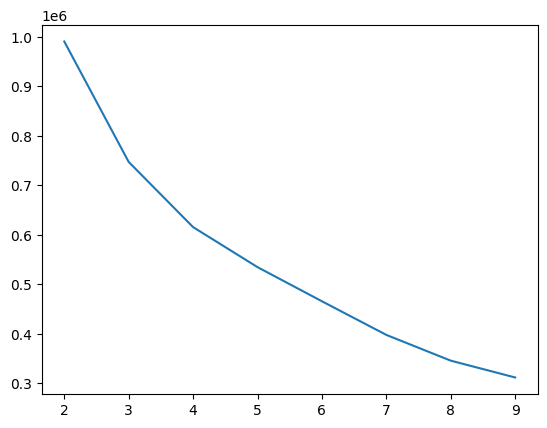

In [ ]:
from sklearn.cluster import KMeans

elbow = []
for k in range(2,10):
  kmeans = KMeans(n_clusters=k, init='k-means++')
  kmeans.fit(df_scaled)
  elbow.append(kmeans.inertia_)

plt.plot(range(2,10), elbow)
plt.show()

**Comments:**
The elbow appears to be happening at 4 clusters

In [ ]:
from sklearn.metrics import silhouette_score

#elbow = []
#for k in range(2,10):
#  kmeans = KMeans(n_clusters=k)
#  kmeans.fit(df_scaled)
#  elbow.append(silhouette_score(df_scaled, kmeans.labels_))

#plt.plot(range(2,10), elbow)
#plt.show()

#### **Implementing K-Means Algorithm**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


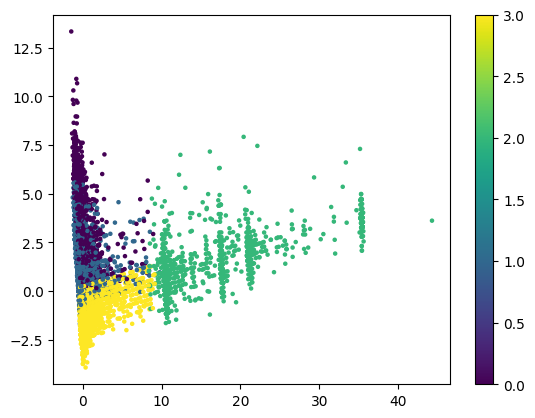

In [ ]:
# KMeans with 3 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_scaled)
plt.scatter(vis[:, 0], vis[:, 1], s=5, c=kmeans.labels_)
plt.colorbar()

### **GMM (Gaussian Mixture Models)**

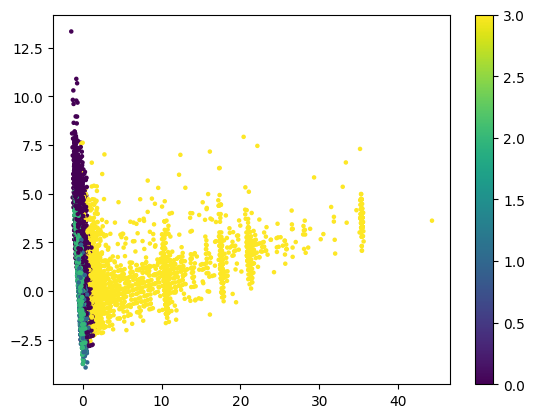

In [ ]:
# GMM Clustering with 4 clusters

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(vis)
plt.scatter(vis[:, 0], vis[:, 1], s=5, c=gmm.predict(vis))
plt.colorbar()
plt.show()

## **Removing / Modelling outliers**

### **LOF**

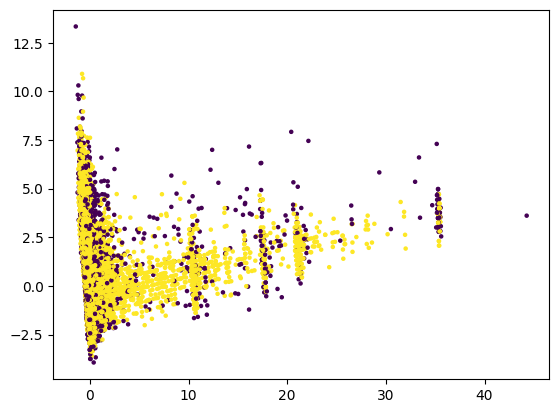

In [ ]:
# LOF
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(contamination=0.15, n_neighbors=5)
y_pred = lof.fit_predict(vis)
plt.scatter(vis[:, 0], vis[:, 1], s=5, c=is_outlier)
plt.show()

In [ ]:
# shape of negative lof
lof.negative_outlier_factor_.shape

(164646,)

In [ ]:
# checking min and max value of negative LOF
lof.negative_outlier_factor_.min(), lof.negative_outlier_factor_.max()

(-7378002154.073769, -0.7930412400727767)

In [ ]:
# adding negative lof to df_scaled DataFrame
df_scaled['lof'] = lof.negative_outlier_factor_

# LOF = 1 (Inlier), Negative LOF = -1 (Inlier) LOF > 1.5 == True is an Inlier
# Adding a column with inlier flag
df_scaled['inlier_flag'] = np.where(df_scaled['lof'] >= -1.5, 1, 0)
df_scaled.head(2)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Current year,Years of Experience,Years to ctc update,lof,inlier_flag
0,-0.019471,-0.049326,-0.028356,-0.048975,-0.252896,-0.474385,0.0,0.028249,0.474385,-0.987137,1
1,-0.204862,-0.119063,0.207589,-0.118060,-0.371663,-0.474385,0.0,-0.207765,0.474385,-0.998718,1


In [ ]:
df_inliers = df_scaled[df_scaled['inlier_flag'] == 1]
df_outliers = df_scaled[df_scaled['inlier_flag'] == 0]
df_inliers.head(2)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Current year,Years of Experience,Years to ctc update,lof,inlier_flag
0,-0.019471,-0.049326,-0.028356,-0.048975,-0.252896,-0.474385,0.0,0.028249,0.474385,-0.987137,1
1,-0.204862,-0.119063,0.207589,-0.118060,-0.371663,-0.474385,0.0,-0.207765,0.474385,-0.998718,1


In [ ]:
df_inliers = df_inliers.drop(['lof','inlier_flag'], axis=1)
df_outliers = df_outliers.drop(['lof','inlier_flag'], axis=1)

### **PCA with Inliers**

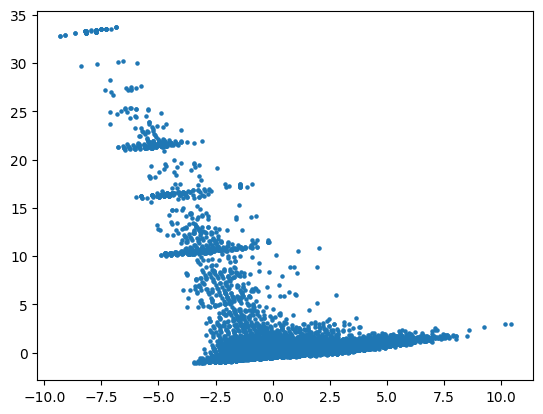

In [ ]:
# PCA to visualize data
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
vis = pca.fit_transform(df_inliers)
plt.scatter(vis[:, 0], vis[:, 1], s = 5)    # s -> Size of marker, c -> color of marker
plt.show()

### **K-Means with Inliers**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


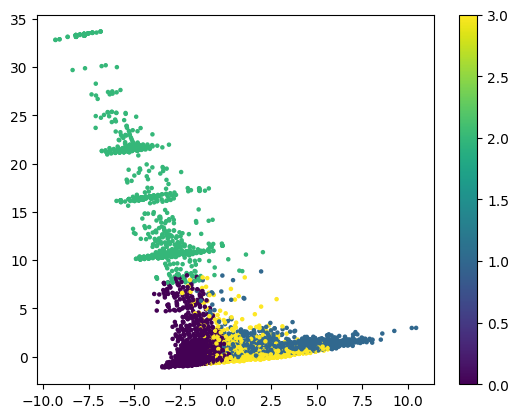

In [ ]:
# KMeans with 3 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_inliers)
plt.scatter(vis[:, 0], vis[:, 1], s=5, c=kmeans.labels_)
plt.colorbar()

### **PCA with Outliers**

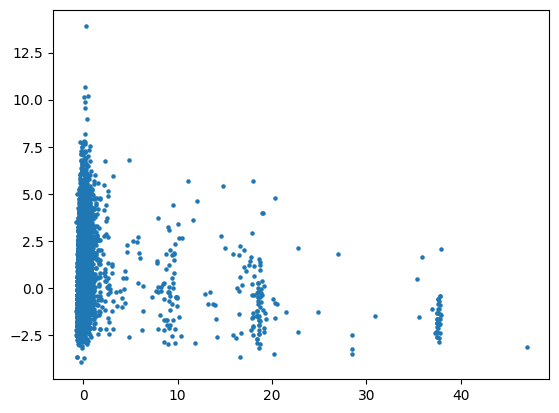

In [ ]:
# PCA to visualize data
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
vis = pca.fit_transform(df_outliers)
plt.scatter(vis[:, 0], vis[:, 1], s = 5)    # s -> Size of marker, c -> color of marker
plt.show()

### **K-Means with Outliers**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


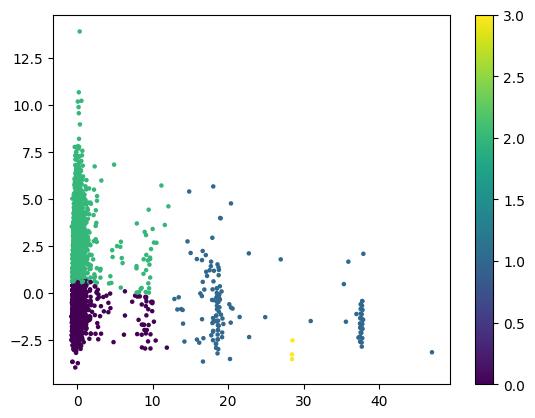

In [ ]:
# KMeans with 3 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_outliers)
plt.scatter(vis[:, 0], vis[:, 1], s=5, c=kmeans.labels_)
plt.colorbar()

### **DBSCAN with Outliers**

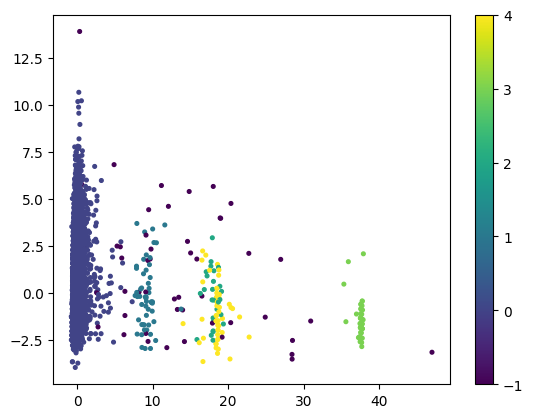

In [ ]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 4, min_samples = 18).fit(vis)
plt.scatter(vis[:,0], vis[:,1], s=7, c=dbsc.labels_)
plt.colorbar()
plt.show()

**Comment:**
DBSCAN appears to be performing well for clustering as compared to K-Means++ or GMM

In [ ]:
np.unique(dbsc.labels_)


array([-1,  0,  1,  2,  3,  4])

# ***4. Actionable Insights and Recommendations***

## **Insights (Summary)**

**Initial EDA:**


- Data has 7 features and 205,843 samples
1. orgyear and ctc_updated_year to be converted from float to int
2. Data cleaning needs to be performed in orgyear
3. ctc has one major outlier, delete that value.

**Data Pre-processing**
3. "Unnamed : 0" column contains unique id hence can be dropped as it is not needed for analysis
4. 'company_hash', 'email_hash','job_position' have > 1000 unique values hence perform target encoding.
5. NULL values present in company_hash (44), orgyear (86), job_position (52564)

For orgyear
- 2025, 2026, 2027, 2028, 2029, 2031 values make no sense as they are in the future
- 2101, 2106, 2107, 2204 values absolutely make no sense as they talk about next century
There may have been extra zeros added at the end of CTC, ignoring those for now.

-------------------------------------------------
**Univariate analysis**

- Data for orgyear appears to be left skewed with mean at 2015 and median at 2016.
- Mean CTC is 2271k, median is 950k, mode is 600k: There are definitely outliers here.
- Most ctcs were updated in year 2019 (mode), Mean is 2019 and median is 2020.
- Years of experience is right skewed with mean 8.88, median 8.0, mode 6.0
- Years to ctc update falls mainly between 3 to 5 with mean 4.37, median 4, mode 5.

Almost all variables have outliers, ctc has one major outlier.

-------------------------------------------------
**Multi variate analysis**

From heatmap,
- company_hash and email_hash have positive correlation of 0.43
- Years of Experience has 0.19 positive correlation with email_hash, ctc, years to ctc update.
- Years of Experience and ctc_updated_year has negative 0.19 correlation.
- ctc and orgyear have negative 0.19 correlation
- ctc has -0.096 with ctc_updated_year and 0.096 with Years to ctc update

From pairplot,
- CTC & Years of Experience / orgyear form a cluster
- Job position and Years of Experience / orgyear form clusters
- There appears to be some outlier

**Insights:**

Histogram:
- Most students have employment start date mean of 2015 and mode of 2018
- Most students have package around 600,000
- Most students have ctc_year_updated in 2019

Scatter plot:
- Scatter plot of ctc & orgyear reveals, **students with latest orgyear have higher ctc.**
- Scatter plot of ctc and years of experience reveals, **ctc is high for students with years of experience < 30 years.**
- **Students with more than 25 years of experience have lower salaries.**
- **CTC is higher for students whose ctc is updated within 3 to 5 years.** Students whose ctc is updated more than 5 years back have low ctc.

-------------------------------------------------
Modelling:
- Just by retaining 5 features we are able to explain 100% of the data
- Hopkins Statistic reveals that data is clusterable since it is ~1
- The elbow appears to be happening at 4 clusters
- DBSCAN appears to be performing well for clustering as compared to K-Means++ or GMM

## **Key / Actionable Insights**

- According to PCA, just by retaining 5 features we are able to explain 100% of the data
- As per elbow method, it appears 4 clusters are ideal.
- Hopkins statistic reveals that data is clusterable as it is ~1
- LOF is able to identify outliers well as opposed to other methods.

**Modelling on Inliers:**
- When K-Means is run on inliers, clusters are not approrpriately formed.

**Modelling on Outliers:**
- Upon plotting outliers separately, they were forming 4 clusters of their own.
- When K-Means is run on outliers, clusters are not approrpriately formed.
- DBSCAN appears to be performing well for clustering as compared to K-Means++ or GMM

</br>

## **Recommendation**

- Based on clusters that have clearly formed, by correlating the cluster data to original dataframe, **we can easily identify characteristics of students in different clusters and customize our learning accordingly.**

- The label data obtained for training dataset can be added as a column, and **supervised learning algorithm can be run for testing dataset to identify the correct cluster new data** (test data) should belong to.
This will also help us evaluate how well our model is performing.

- As per pairplot, CTC and Years of Experience form clusters and as per scatter plot, Students with about 25-30 years or lower experience tend to have higher salary, as compared to students with >35 years experience.
As per these plots and modelling results, **it appears the clusters are formed on bases of CTC and Years of Experience, thus learning by CompanyX can be customized accordingly.**

**Customer Segmentation:**
- Students with lower CTC: Have probably joined because they are willing to earn higher CTC.
- Students with medium CTC: Have probably joined because they are willing to make a role switch by expand their knowledge.
- Students with higher CTC: Have probably joined to strengthen their knowledge in the field.

